In [1]:
# Import relevant modules
import cv2
import numpy as np
from matplotlib import pyplot as plt
from helper_functions.utils import *

TRAIN_IMGS_DIR = "../data/train/combine"

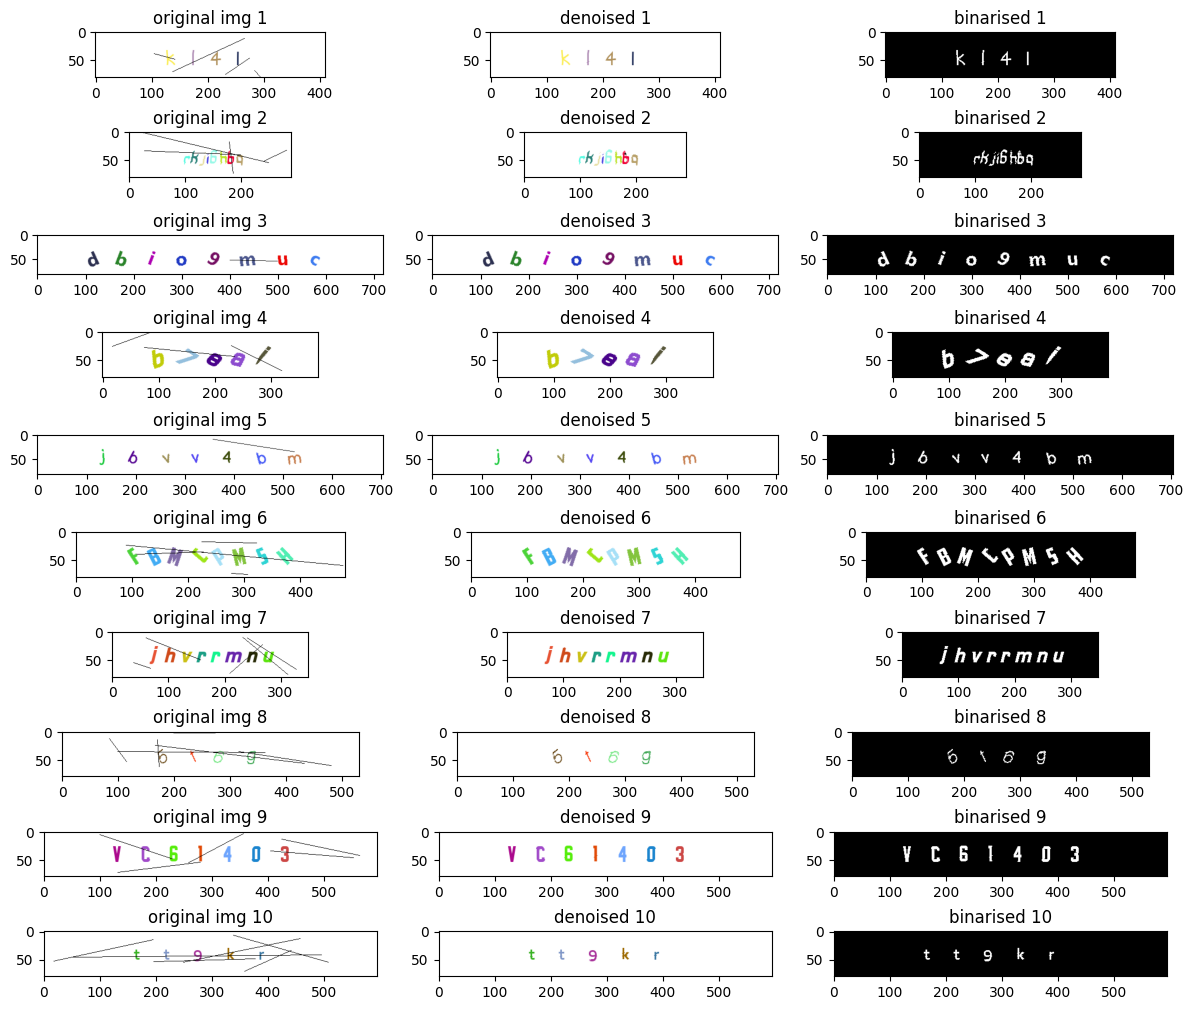

In [2]:
from helper_functions.preprocessing import replace_black_with_median, binarization_max_contrast

"""
Prep some binarised images first before segmentation
"""
NUM_IMGS = 10
imgs = get_n_random_train_imgs(TRAIN_IMGS_DIR, NUM_IMGS)
denoised_imgs = [replace_black_with_median(img.copy()) for img in imgs]

# Apply thresholding to binarize the image
gray_denoised_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in denoised_imgs]

binarised_imgs = [binarization_max_contrast(img) for img in denoised_imgs]

fig, axes = plt.subplots(nrows=NUM_IMGS, ncols=3, figsize=(12, NUM_IMGS))
for i in range(NUM_IMGS):
    imshow_bulk(imgs[i], f"original img {i+1}", axes[i,0])
    imshow_bulk(denoised_imgs[i], f"denoised {i+1}", axes[i,1])
    imshow_bulk(binarised_imgs[i], f"binarised {i+1}", axes[i,2])
plt.tight_layout()
plt.show()



In [3]:
"""
Connected Component Analysis (CCA)
"""
# # Find connected components
# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# char_images = []
# for cnt in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     char_images.append(binary[y:y+h, x:x+w])  # Crop character

# # Sort by x-coordinates to maintain reading order
# char_images = sorted(char_images, key=lambda im: im.shape[1])

# # Display segmented characters
# for i, char in enumerate(char_images):
#     plt.subplot(21, len(char_images), i+2)
#     plt.imshow(char, cmap='gray')
#     plt.axis('off')


'\nConnected Component Analysis (CCA)\n'

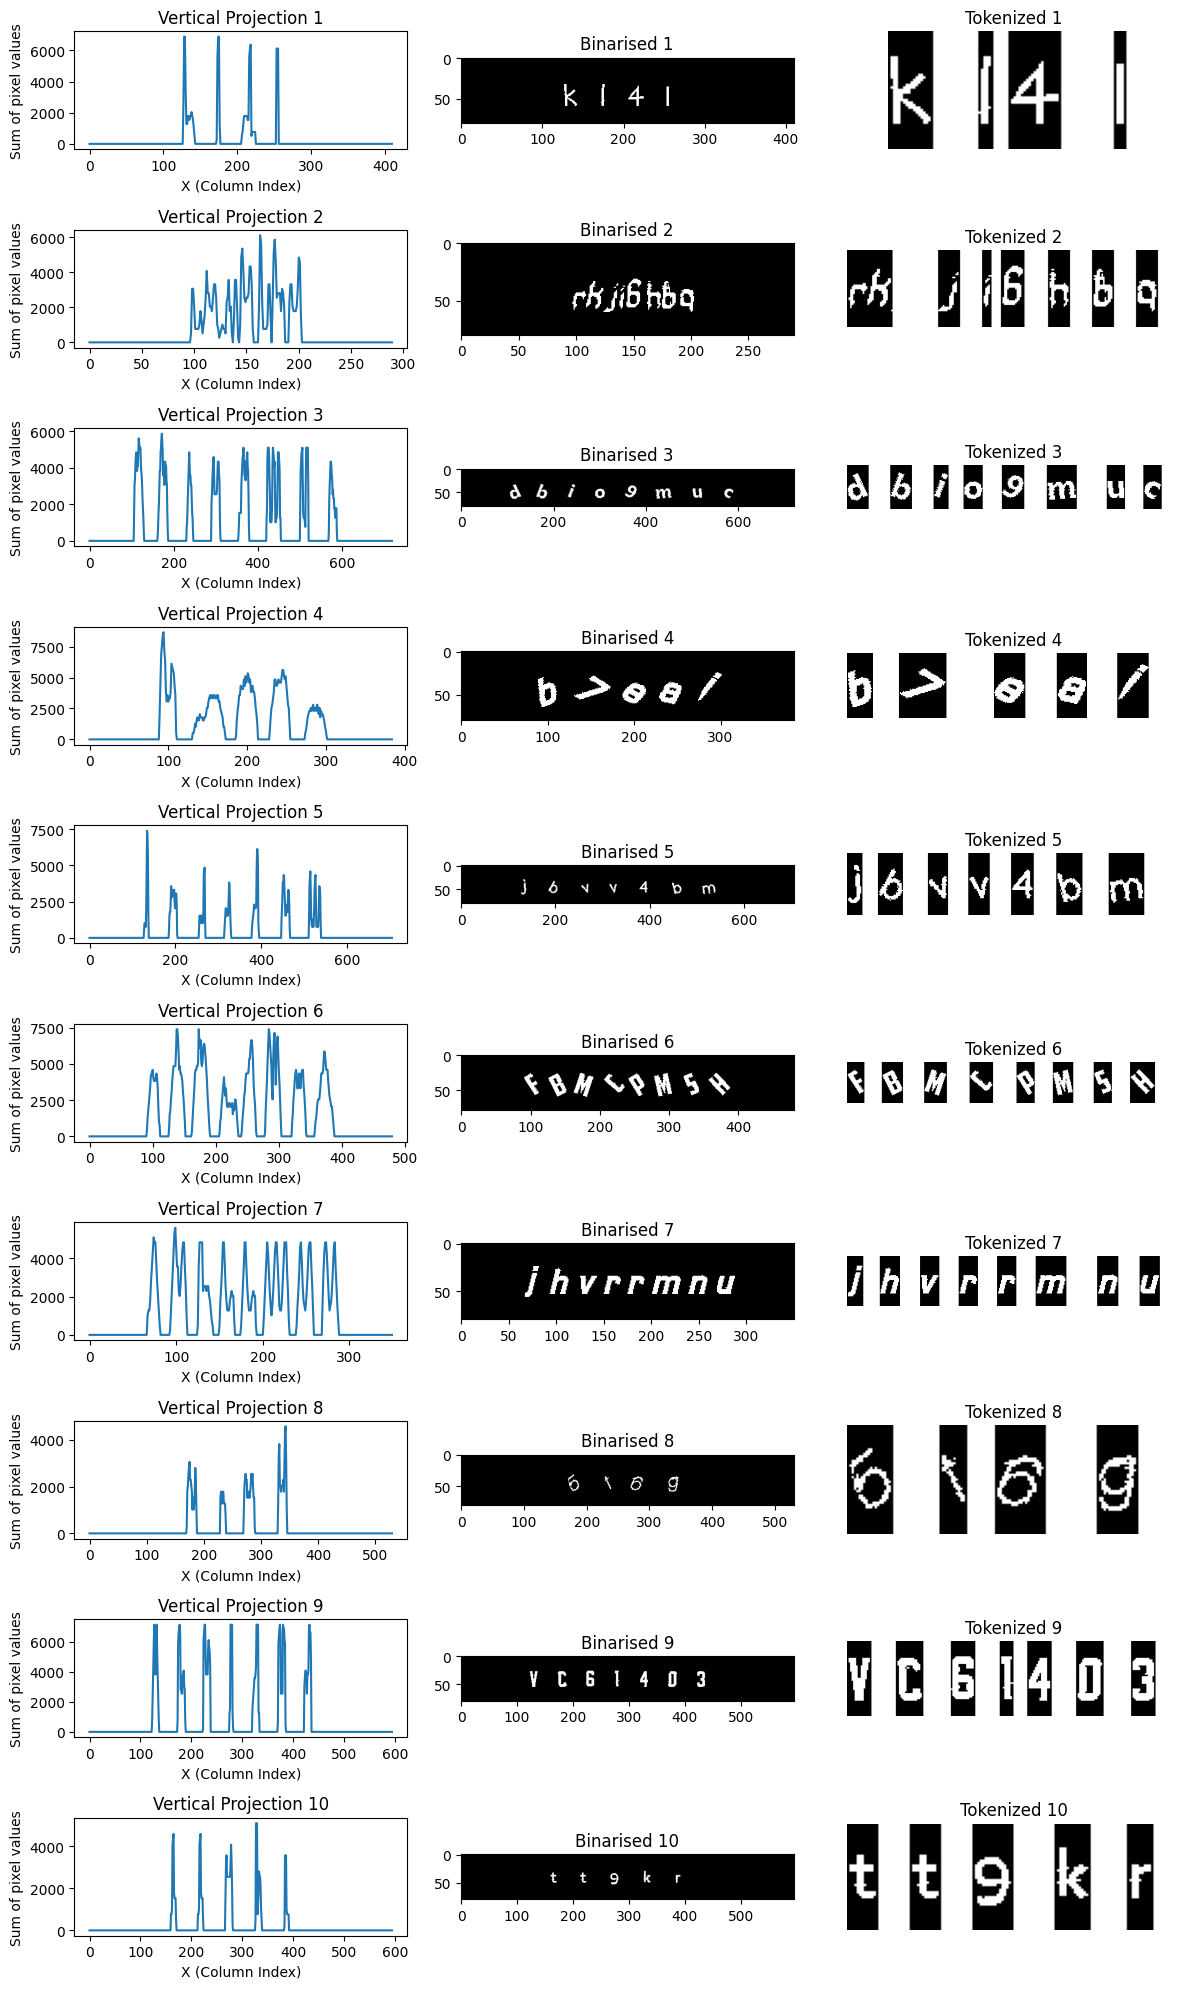

In [4]:
"""
Vertical Projection (to get the horizontal segments of characters)
"""
from helper_functions.segmentation import get_segmented_characters_with_vertical_projection

# Compute vertical projection (sum of pixel values along columns)
vertical_projs = [np.sum(binary, axis=0) for binary in binarised_imgs]
all_char_images_vert_proj = get_segmented_characters_with_vertical_projection(binarised_imgs)

# Create a figure
fig, axes = plt.subplots(NUM_IMGS, 3, figsize=(12, 2 * NUM_IMGS))

# Loop over each image
for i in range(NUM_IMGS):
    # Plot vertical projection in the first column
    ax1 = axes[i, 0]  # First column
    ax1.plot(vertical_projs[i])  # Plot the vertical projection
    ax1.set_title(f"Vertical Projection {i + 1}")
    ax1.set_xlabel("X (Column Index)")
    ax1.set_ylabel("Sum of pixel values")

    # Plot binarised image in the second column
    ax2 = axes[i, 1]  # Second column
    imshow_bulk(binarised_imgs[i], f"Binarised {i + 1}", ax2)

    # Plot tokenized characters in the third column
    ax3 = axes[i, 2]  # Third column
    char_imgs = all_char_images_vert_proj[i]
    combined_char_imgs = get_combined_char_imgs(char_imgs)
    
    if len(combined_char_imgs) > 0:
        ax3.imshow(cv2.cvtColor(combined_char_imgs, cv2.COLOR_BGR2RGB))
        ax3.set_title(f"Tokenized {i + 1}")
        ax3.axis('off')  # Turn off axes for a cleaner display

plt.tight_layout()
plt.show()

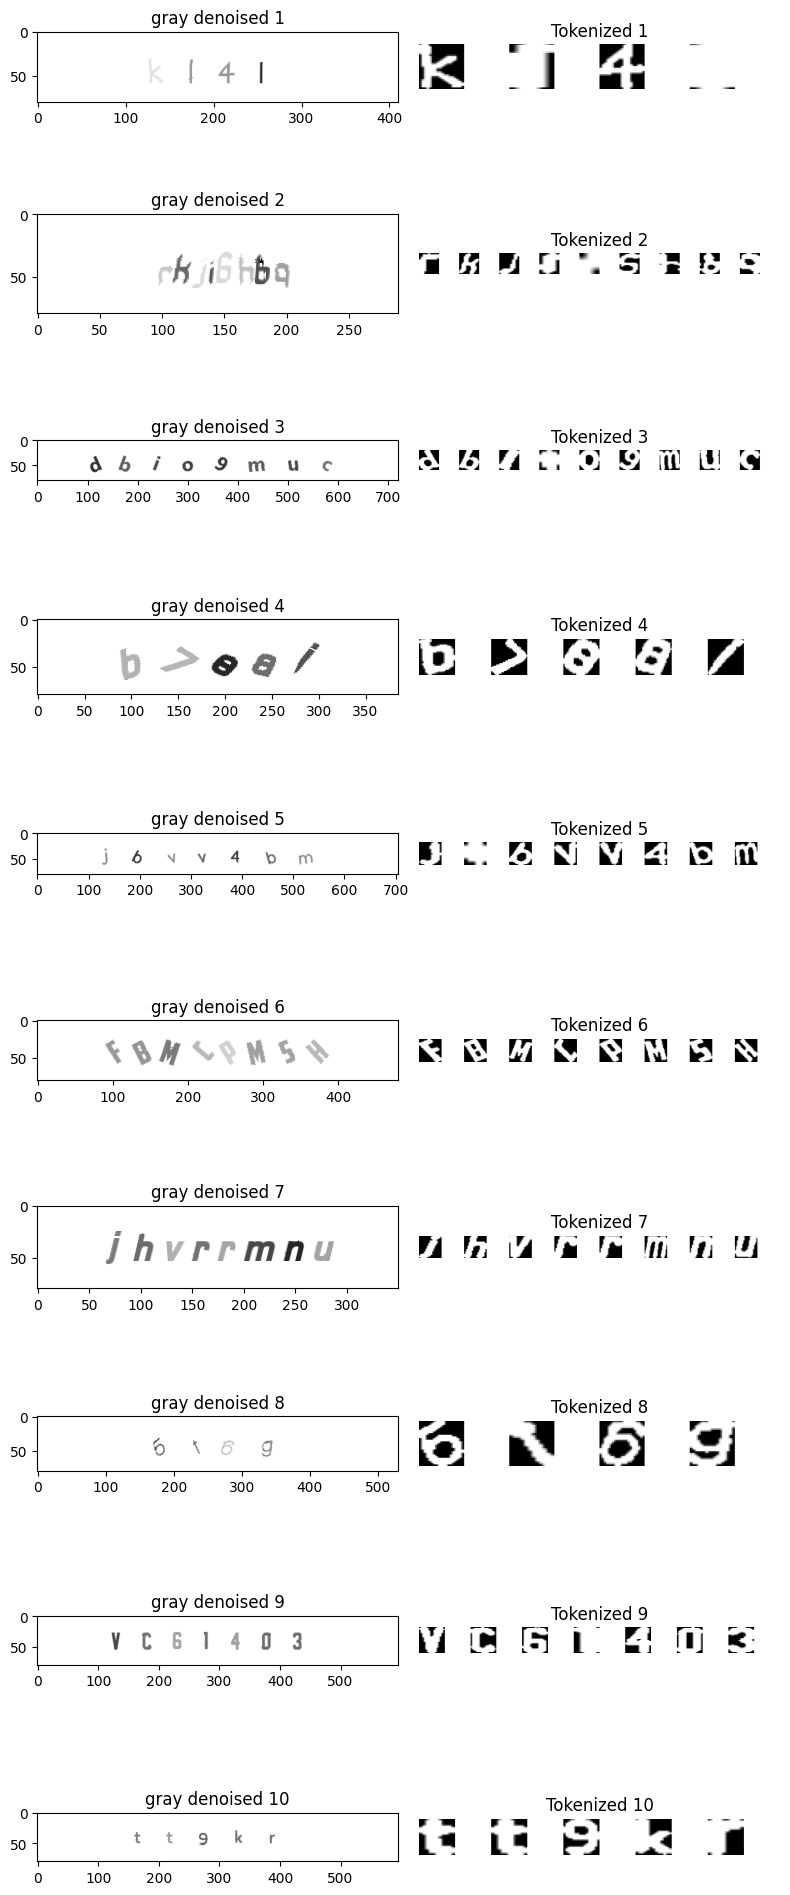

In [5]:
"""
Contour segmentation
"""
# Apply Gaussian blur to reduce noise
blurred_imgs = [cv2.GaussianBlur(gray, (5, 5), 0) for gray in gray_denoised_imgs]

# Apply adaptive thresholding
thresholds = [cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 2) for blurred in blurred_imgs]

# Find contours
all_contours = [cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] for thresh in thresholds]

# Filter out small contours (likely noise) and sort from left to right
all_filtered_contours = [sorted([c for c in contours if cv2.contourArea(c) > 0], key=lambda c: cv2.boundingRect(c)[0]) for contours in all_contours]

all_char_images_contour = []
for filtered_contours, thresh in zip(all_filtered_contours, thresholds):
    # Process each character
    char_images = []
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        char = thresh[y:y+h, x:x+w]
        char = cv2.resize(char, (28, 28))  # Resize to fit model input
        char_images.append(char)
    all_char_images_contour.append(char_images)


# Create a figure
fig, axes = plt.subplots(NUM_IMGS, 2, figsize=(8, 2 * NUM_IMGS))

# Loop over each image
for i in range(NUM_IMGS):
    # Plot binarised image
    ax1 = axes[i, 0]
    imshow_bulk(gray_denoised_imgs[i], f"gray denoised {i + 1}", ax1)

    # Plot tokenized characters for contours
    ax2 = axes[i, 1] 
    tokenized_imgs_contour = all_char_images_contour[i]
    
    # Create a list to hold the images with spacing
    tokenized_with_spacing_contour = []
    for char_img in tokenized_imgs_contour:
        tokenized_with_spacing_contour.append(char_img)  # Add the character image
        # Add a white image for spacing
        blank_image = np.ones_like(char_img) * 255
        tokenized_with_spacing_contour.append(blank_image)
    
    # Combine tokenized characters with spacing
    if tokenized_with_spacing_contour:
        combined_img = np.hstack(tokenized_with_spacing_contour)
        
        ax2.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f"Tokenized {i + 1}")
        ax2.axis('off')  # Turn off axes for a cleaner display

    # Plot tokenized characters
    ax2 = axes[i, 1] 
    tokenized_imgs_contour = all_char_images_contour[i]
    
    # Create a list to hold the images with spacing
    tokenized_with_spacing_contour = []
    for char_img in tokenized_imgs_contour:
        tokenized_with_spacing_contour.append(char_img)  # Add the character image
        # Add a white image for spacing
        blank_image = np.ones_like(char_img) * 255
        tokenized_with_spacing_contour.append(blank_image)
    
    # Combine tokenized characters with spacing
    if tokenized_with_spacing_contour:
        combined_img = np.hstack(tokenized_with_spacing_contour)
        
        ax2.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f"Tokenized {i + 1}")
        ax2.axis('off')  # Turn off axes for a cleaner display
plt.tight_layout()
plt.show()
